In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import nnls
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [57]:
file_path = 'Bloomberg_apm.xlsx'

# Load the dataset from the provided Excel file
data = pd.read_excel(file_path, sheet_name='Data', parse_dates=True)

# Ensure the data is in ascending order (oldest first)
data = data.sort_values(by='Date', ascending=True)

# Drop rows with NaN values
data = data.dropna(how='any')

In [58]:
# Min-Max normalization function
def min_max_normalize(series):
    return (series) / (series.max() - series.min())


In [59]:
def normalize_to_cmi_scale(data_series):
    min_value = data_series.min()
    max_value = data_series.max()
    # Apply min-max normalization to the range [-2, 2]
    return -2 + ((data_series - min_value) / (max_value - min_value)) * 4

In [60]:
# Dynamic threshold calculation for second derivative based on rolling average and standard deviation
def dynamic_threshold(data_series, row_index, window=12, multiplier=2):
    # Compute the rolling mean and standard deviation up to the current row_index (excluding future data)
    rolling_mean = data_series.iloc[:row_index + 1].rolling(window=window).mean().iloc[-1]
    rolling_std = data_series.iloc[:row_index + 1].rolling(window=window).std().iloc[-1]

    # Return the scalar value of the dynamic threshold at the current row
    if pd.notna(rolling_mean) and pd.notna(rolling_std):
        return rolling_mean + (rolling_std * multiplier)
    else:
        return 0  # Handle cases where there isn't enough data for the rolling window


In [61]:
# Logic for each variable based on robust thresholds, rate of change, and economic significance

# 1. ISM Manufacturing PMI
def pmi_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if ((value >= 55) and (change > 0)) or ( (value > 48) and (second_derivative > second_derivative_threshold)):
        return 2  # Strong expansion or sharply accelerating
    elif (value >= 50):
        return 1  # Slowing but still expansion
    elif ((value <= 45) and (change < 0)) or ((value < 52) and (second_derivative < -second_derivative_threshold)):
        return -2  # Contraction or sharp fall
    elif (value <= 50):
        return -1  # Slowdown
    return 0  # Neutral/stable

# 2. ISM Non-Manufacturing PMI
def non_mfg_pmi_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if ((value >= 55) and (change > 0)) or ((value > 55) and (second_derivative > second_derivative_threshold)):
        return 2  # Strong expansion or sharply accelerating
    elif (value >= 50):
        return 1  # Mild slowdown but still growing
    elif ((value <= 45) and (change < 0)) or ((value < 55) and (second_derivative < -second_derivative_threshold)):
        return -2  # Contraction or sharp fall
    elif (value <= 50):
        return -1  # Mild slowdown
    return 0  # Stable

# Inverse

# 3. Initial Jobless Claims (compared to historical average and rate of change)
def jobless_claims_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > rolling_mean + 2*rolling_std) or ((change > 0) and (second_derivative > second_derivative_threshold)):
        return -2  # Sharp rise in jobless claims
    elif (value > rolling_mean + rolling_std):
        return -1  # Mild increase
    elif (value < rolling_mean - 2*rolling_std) or ((change < 0) and (second_derivative < -second_derivative_threshold)):
        return 2  # Sharp decline
    elif (value < rolling_mean - rolling_std):
        return 1  # Mild decline
    return 0  # Neutral

# 4. US Capacity Utilization
def capacity_utilization_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > rolling_mean + 2*rolling_std) or ((change > 0) and (second_derivative > second_derivative_threshold)):
        return 2  # Full capacity, expansion, sharply accelerating
    elif (value > rolling_mean + rolling_std):
        return 1  # High capacity but slight decline, decelerating
    elif (value < rolling_mean - 2*rolling_std) or ((change < 0) and (second_derivative < -second_derivative_threshold)):
        return -2  # Sharp underutilization, contraction
    elif (value < rolling_mean - rolling_std):
        return -1  # Moderate slowdown but recovering
    return 0  # Neutral

# 5. Yield Curve (10-year less 2-year spread, signaling economic expectations)
def yield_curve_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > 0.02 and change > 0) or (value > 0.01 and second_derivative > second_derivative_threshold):
        return 2  # Steep curve, growth expectations
    elif (value > 0 and change < 0):
        return 1  # Flattening but still positive
    elif (value < 0 and change < 0) or (value < 0 and second_derivative < -second_derivative_threshold):
        return -2  # Inverted curve, recession expectations
    elif (value < 0 and change > 0):
        return -1  # Mild recovery from inversion
    return 0  # Neutral

# 6. Rail Freight Carloads (YoY %)
def rail_freight_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > rolling_mean + 2*rolling_std) or ((change > 0) and (second_derivative > second_derivative_threshold)):
        return 2  # Full capacity, expansion, sharply accelerating
    elif (value > rolling_mean + rolling_std):
        return 1  # High capacity but slight decline, decelerating
    elif (value < rolling_mean - 2*rolling_std) or ((change < 0) and (second_derivative < -second_derivative_threshold)):
        return -2  # Sharp underutilization, contraction
    elif (value < rolling_mean - rolling_std):
        return -1  # Moderate slowdown but recovering
    return 0  # Neutral

# 7. Baltic Dry Index (Global shipping demand)
def baltic_dry_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > rolling_mean + 2*rolling_std) or ((change > 0) and (second_derivative > second_derivative_threshold)):
        return 2  # Full capacity, expansion, sharply accelerating
    elif (value > rolling_mean + rolling_std):
        return 1  # High capacity but slight decline, decelerating
    elif (value < rolling_mean - 2*rolling_std) or ((change < 0) and (second_derivative < -second_derivative_threshold)):
        return -2  # Sharp underutilization, contraction
    elif (value < rolling_mean - rolling_std):
        return -1  # Moderate slowdown but recovering
    return 0  # Neutral

# 8. CPI (YOY Index)
def cpi_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > 2 and change > 0) or (value > rolling_mean and second_derivative > second_derivative_threshold):
        return -2  # High inflation, sharply worsening
    elif value > 2 and change < 0:
        return -1  # High but declining inflation
    elif (value < 2 and change < 0) or (value < rolling_mean and second_derivative < -second_derivative_threshold):
        return 2  # Low inflation, improving sharply
    elif value < 2 and change > 0:
        return 1  # Low but rising inflation
    return 0  # Stable inflation

# 9. Producer Price Index (PPI)
def ppi_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > rolling_mean + rolling_std and change > 0) or (value > rolling_mean and second_derivative > second_derivative_threshold):
        return -2  # High input costs, sharply increasing
    elif value > rolling_mean and change < 0:
        return -1  # Declining but still high input costs
    elif (value < rolling_mean - rolling_std and change < 0) or (value < rolling_mean and second_derivative < -second_derivative_threshold):
        return 2  # Low input costs, improving sharply
    elif value < rolling_mean and change > 0:
        return 1  # Low but rising input costs
    return 0  # Stable input costs

# 10. U.S. Import Price Inflation
def import_price_inflation_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > rolling_mean + rolling_std and change > 0) or (value > rolling_mean and second_derivative > second_derivative_threshold):
        return -2  # High import inflation, sharply increasing
    elif value > rolling_mean and change < 0:
        return -1  # Declining but still high import inflation
    elif (value < rolling_mean - rolling_std and change < 0) or (value < rolling_mean and second_derivative < -second_derivative_threshold):
        return 2  # Low import inflation, improving sharply
    elif value < rolling_mean and change > 0:
        return 1  # Low but increasing import inflation
    return 0  # Stable import inflation


# 11. Retail Sales YoY %
def retail_sales_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > rolling_mean + 2*rolling_std) or ((change > 0) and (second_derivative > second_derivative_threshold)):
        return 2  # Full capacity, expansion, sharply accelerating
    elif (value > rolling_mean + rolling_std):
        return 1  # High capacity but slight decline, decelerating
    elif (value < rolling_mean - 2*rolling_std) or ((change < 0) and (second_derivative < -second_derivative_threshold)):
        return -2  # Sharp underutilization, contraction
    elif (value < rolling_mean - rolling_std):
        return -1  # Moderate slowdown but recovering
    return 0  # Neutral

# 12. Real Bond Yield (10Y)
def real_bond_yield_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > rolling_mean + rolling_std and change > 0) or (value > rolling_mean and second_derivative > second_derivative_threshold):
        return 2  # Rising real bond yields, sharply accelerating
    elif value > rolling_mean and (change < 0 or second_derivative < -second_derivative_threshold):
        return 1  # Declining but still positive bond yields
    elif (value < rolling_mean - rolling_std and change < 0) or (value < rolling_mean and second_derivative < -second_derivative_threshold):
        return -2  # Negative real bond yields, sharply decelerating
    elif value < rolling_mean and change > 0:
        return -1  # Mild improvement but still negative
    return 0  # Neutral

# 13. M2 Money Supply
def m2_money_supply_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > rolling_mean + 2*rolling_std) or ((change > 0) and (second_derivative > second_derivative_threshold)):
        return 2  # Full capacity, expansion, sharply accelerating
    elif (value > rolling_mean + rolling_std):
        return 1  # High capacity but slight decline, decelerating
    elif (value < rolling_mean - 2*rolling_std) or ((change < 0) and (second_derivative < -second_derivative_threshold)):
        return -2  # Sharp underutilization, contraction
    elif (value < rolling_mean - rolling_std):
        return -1  # Moderate slowdown but recovering
    return 0  # Neutral

# 14. Credit Managers' Index
def credit_managers_index_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > rolling_mean + 2*rolling_std) or ((change > 0) and (second_derivative > second_derivative_threshold)):
        return 2  # Full capacity, expansion, sharply accelerating
    elif (value > rolling_mean + rolling_std):
        return 1  # High capacity but slight decline, decelerating
    elif (value < rolling_mean - 2*rolling_std) or ((change < 0) and (second_derivative < -second_derivative_threshold)):
        return -2  # Sharp underutilization, contraction
    elif (value < rolling_mean - rolling_std):
        return -1  # Moderate slowdown but recovering
    return 0  # Neutral

# 15. Russell - S&P YoY
def russell_sp_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > rolling_mean + 2*rolling_std) or ((change > 0) and (second_derivative > second_derivative_threshold)):
        return 2  # Full capacity, expansion, sharply accelerating
    elif (value > rolling_mean + rolling_std):
        return 1  # High capacity but slight decline, decelerating
    elif (value < rolling_mean - 2*rolling_std) or ((change < 0) and (second_derivative < -second_derivative_threshold)):
        return -2  # Sharp underutilization, contraction
    elif (value < rolling_mean - rolling_std):
        return -1  # Moderate slowdown but recovering
    return 0  # Neutral

# 16. US - World
def us_world_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > rolling_mean + 2*rolling_std) or ((change > 0) and (second_derivative > second_derivative_threshold)):
        return 2  # Full capacity, expansion, sharply accelerating
    elif (value > rolling_mean + rolling_std):
        return 1  # High capacity but slight decline, decelerating
    elif (value < rolling_mean - 2*rolling_std) or ((change < 0) and (second_derivative < -second_derivative_threshold)):
        return -2  # Sharp underutilization, contraction
    elif (value < rolling_mean - rolling_std):
        return -1  # Moderate slowdown but recovering
    return 0  # Neutral

#Inverse

# 17. Unit Labor Cost (YoY)
def unit_labor_cost_yoy_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > rolling_mean + rolling_std and change > 0) or (value > rolling_mean and second_derivative > second_derivative_threshold):
        return -2  # Rising labor costs YoY, sharply increasing
    elif value > rolling_mean and change < 0:
        return -1  # Declining but still high labor costs YoY
    elif (value < rolling_mean - rolling_std and change < 0) or (value < rolling_mean and second_derivative < -second_derivative_threshold):
        return 2  # Declining labor costs YoY, improving sharply
    elif value < rolling_mean and change > 0:
        return 1  # Mild rise in labor costs YoY
    return 0  # Stable labor costs YoY

# 18. S&P 500 3-Year Change
def sp500_3yr_change_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > rolling_mean + 2*rolling_std) or ((change > 0) and (second_derivative > second_derivative_threshold)):
        return 2  # Full capacity, expansion, sharply accelerating
    elif (value > rolling_mean + rolling_std):
        return 1  # High capacity but slight decline, decelerating
    elif (value < rolling_mean - 2*rolling_std) or ((change < 0) and (second_derivative < -second_derivative_threshold)):
        return -2  # Sharp underutilization, contraction
    elif (value < rolling_mean - rolling_std):
        return -1  # Moderate slowdown but recovering
    return 0  # Neutral

# 19. LEI (Leading Economic Indicator)
def lei_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > rolling_mean + 2*rolling_std) or ((change > 0) and (second_derivative > second_derivative_threshold)):
        return 2  # Full capacity, expansion, sharply accelerating
    elif (value > rolling_mean + rolling_std):
        return 1  # High capacity but slight decline, decelerating
    elif (value < rolling_mean - 2*rolling_std) or ((change < 0) and (second_derivative < -second_derivative_threshold)):
        return -2  # Sharp underutilization, contraction
    elif (value < rolling_mean - rolling_std):
        return -1  # Moderate slowdown but recovering
    return 0  # Neutral

# 20. Volatility Index (VIX)
def vix_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > 30 and change > 0) or (value > 25 and second_derivative > second_derivative_threshold):
        return -2  # High volatility, sharply increasing
    elif value > 20 and change < 0:
        return -1  # Volatility high but decreasing
    elif (value < 15 and change < 0) or (value < 20 and second_derivative < -second_derivative_threshold):
        return 2  # Low volatility, decreasing sharply
    elif value < 20 and change > 0:
        return 1  # Volatility rising but still low
    return 0  # Stable

# 21. New Orders to Inventory ratio
def new_orders_inventory_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > rolling_mean + 2*rolling_std) or ((change > 0) and (second_derivative > second_derivative_threshold)):
        return 2  # Full capacity, expansion, sharply accelerating
    elif (value > rolling_mean + rolling_std):
        return 1  # High capacity but slight decline, decelerating
    elif (value < rolling_mean - 2*rolling_std) or ((change < 0) and (second_derivative < -second_derivative_threshold)):
        return -2  # Sharp underutilization, contraction
    elif (value < rolling_mean - rolling_std):
        return -1  # Moderate slowdown but recovering
    return 0  # Neutral

#Inverse

# 22. Oil Prices
def oil_price_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > rolling_mean + rolling_std and change > 0) or (value > rolling_mean and second_derivative > second_derivative_threshold):
        return -2  # Sharp rise in oil prices, increasing
    elif value > rolling_mean and change < 0:
        return -1  # Declining but still high oil prices
    elif (value < rolling_mean - rolling_std and change < 0) or (value < rolling_mean and second_derivative < -second_derivative_threshold):
        return 2  # Low oil prices, improving
    elif value < rolling_mean and change > 0:
        return 1  # Rising but still low prices
    return 0  # Stable oil prices

# 23. New Home Sales
def new_home_sales_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > rolling_mean + 2*rolling_std) or ((change > 0) and (second_derivative > second_derivative_threshold)):
        return 2  # Full capacity, expansion, sharply accelerating
    elif (value > rolling_mean + rolling_std):
        return 1  # High capacity but slight decline, decelerating
    elif (value < rolling_mean - 2*rolling_std) or ((change < 0) and (second_derivative < -second_derivative_threshold)):
        return -2  # Sharp underutilization, contraction
    elif (value < rolling_mean - rolling_std):
        return -1  # Moderate slowdown but recovering
    return 0  # Neutral


# 25. Michigan Consumer Sentiment
def consumer_sentiment_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > rolling_mean + 2*rolling_std) or ((change > 0) and (second_derivative > second_derivative_threshold)):
        return 2  # Full capacity, expansion, sharply accelerating
    elif (value > rolling_mean + rolling_std):
        return 1  # High capacity but slight decline, decelerating
    elif (value < rolling_mean - 2*rolling_std) or ((change < 0) and (second_derivative < -second_derivative_threshold)):
        return -2  # Sharp underutilization, contraction
    elif (value < rolling_mean - rolling_std):
        return -1  # Moderate slowdown but recovering
    return 0  # Neutral

# 26. Transport/ Utilities ratio
def dow_tran_util_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > rolling_mean + 2*rolling_std) or ((change > 0) and (second_derivative > second_derivative_threshold)):
        return 2  # Full capacity, expansion, sharply accelerating
    elif (value > rolling_mean + rolling_std):
        return 1  # High capacity but slight decline, decelerating
    elif (value < rolling_mean - 2*rolling_std) or ((change < 0) and (second_derivative < -second_derivative_threshold)):
        return -2  # Sharp underutilization, contraction
    elif (value < rolling_mean - rolling_std):
        return -1  # Moderate slowdown but recovering
    return 0  # Neutral

# 27. BreakEven Inflation
def breakeven_inflation_logic(value, change, second_derivative, rolling_mean, rolling_std, second_derivative_threshold):
    if (value > rolling_mean + rolling_std and change > 0) or (value > rolling_mean and second_derivative > second_derivative_threshold):
        return -2  # High inflation expectations, sharply worsening
    elif value > rolling_mean and change < 0:
        return -1  # High but declining inflation expectations
    elif (value < rolling_mean - rolling_std and change < 0) or (value < rolling_mean and second_derivative < -second_derivative_threshold):
        return 2  # Low inflation expectations, sharply improving
    elif value < rolling_mean and change > 0:
        return 1  # Low but rising inflation expectations
    return 0  # Stable



In [62]:
# Apply the logic to the dataset, including rate of change
def construct_CMI(data):

    # ISM Manufacturing PMI
    data['PMI_Change'] = data['ISM Manufacturing PMI'].diff()
    data['PMI_Second_Derivative'] = data['PMI_Change'].diff()

    # ISM Non-Manufacturing PMI
    data['Non_Mfg_PMI_Change'] = data['ISM Non-manufacturing PMI'].diff()
    data['Non_Mfg_PMI_Second_Derivative'] = data['Non_Mfg_PMI_Change'].diff()

    # Initial Jobless Claims
    data['Jobless_Claims_Change'] = data['Initial Jobless Claims, 4 wk avg'].diff()
    data['Jobless_Claims_Second_Derivative'] = data['Jobless_Claims_Change'].diff()

    # US Capacity Utilization
    data['Capacity_Utilization_Change'] = data['US Capacity Utilization'].diff()
    data['Capacity_Utilization_Second_Derivative'] = data['Capacity_Utilization_Change'].diff()

    # Yield Curve
    data['Yield_Curve_Change'] = data['Yield Curve (10-year less 2-year)'].diff()
    data['Yield_Curve_Second_Derivative'] = data['Yield_Curve_Change'].diff()

    # Rail Freight Carloads
    data['Rail_Freight_Change'] = data['Rail Freight Carloads, YoY %'].diff()
    data['Rail_Freight_Second_Derivative'] = data['Rail_Freight_Change'].diff()

    # Baltic Dry Index
    data['Baltic_Dry_Change'] = data['Baltic Dry Index'].diff()
    data['Baltic_Dry_Second_Derivative'] = data['Baltic_Dry_Change'].diff()

    # CPI YOY Index
    data['CPI_Change'] = data['CPI YOY Index'].diff()
    data['CPI_Second_Derivative'] = data['CPI_Change'].diff()

    # Producer Price Index (PPI)
    data['PPI_Change'] = data['Producer Price Index'].diff()
    data['PPI_Second_Derivative'] = data['PPI_Change'].diff()

    # U.S. Import Price Inflation
    data['Import_Price_Change'] = data['U.S. Import Price Inflation'].diff()
    data['Import_Price_Second_Derivative'] = data['Import_Price_Change'].diff()

    # Retail Sales YoY %
    data['Retail_Sales_Change'] = data['Retail Sales YoY %'].diff()
    data['Retail_Sales_Second_Derivative'] = data['Retail_Sales_Change'].diff()

    # Real Bond Yield (10Y)
    data['Real_Bond_Yield_Change'] = data['10Y Bond Yield, Real Rate'].diff()
    data['Real_Bond_Yield_Second_Derivative'] = data['Real_Bond_Yield_Change'].diff()

    # M2 Money Supply
    data['M2_Money_Change'] = data['M2 Money Supply'].diff()
    data['M2_Money_Second_Derivative'] = data['M2_Money_Change'].diff()

    # Credit Managers' Index
    data['Credit_Managers_Change'] = data['Credit Managers’ Index'].diff()
    data['Credit_Managers_Second_Derivative'] = data['Credit_Managers_Change'].diff()

    # Russell - S&P YoY
    data['Russell_SP_Change'] = data['Russell - S&P YoY'].diff()
    data['Russell_SP_Second_Derivative'] = data['Russell_SP_Change'].diff()

    # US - World
    data['US_World_Change'] = data['US - World'].diff()
    data['US_World_Second_Derivative'] = data['US_World_Change'].diff()

    # Unit Labor Cost YoY %
    data['Unit_Labor_Cost_YoY_Change'] = data['Unit labor cost YoY %'].diff()
    data['Unit_Labor_Cost_YoY_Second_Derivative'] = data['Unit_Labor_Cost_YoY_Change'].diff()

    # Oil Price
    data['Oil_Price_Change'] = data['Oil Price'].diff()
    data['Oil_Price_Second_Derivative'] = data['Oil_Price_Change'].diff()

    # New Home Sales YoY %
    data['New_Home_Sales_Change'] = data['New Home Sales YoY %'].diff()
    data['New_Home_Sales_Second_Derivative'] = data['New_Home_Sales_Change'].diff()

    # Michigan Consumer Sentiment
    data['Consumer_Sentiment_Change'] = data['Michigan Consumer Sentiment'].diff()
    data['Consumer_Sentiment_Second_Derivative'] = data['Consumer_Sentiment_Change'].diff()

    # Dow TRAN/UTIL ratio
    data['Dow_TRAN_UTIL_Change'] = data['Dow TRAN/UTIL'].diff()
    data['Dow_TRAN_UTIL_Second_Derivative'] = data['Dow_TRAN_UTIL_Change'].diff()

    # Breakeven Inflation
    data['Breakeven_Inflation_Change'] = data['U.S. 10-Year Breakeven Inflation Rate'].diff()
    data['Breakeven_Inflation_Second_Derivative'] = data['Breakeven_Inflation_Change'].diff()

    # New Orders to Inventory ratio
    data['New_Orders_Inventory_Change'] = data['Non Defence New Orders/Inventory'].diff()
    data['New_Orders_Inventory_Second_Derivative'] = data['New_Orders_Inventory_Change'].diff()

    # ISM Manufacturing PMI
    data['PMI_CMI'] = data.apply(lambda row: pmi_logic(row['ISM Manufacturing PMI'],
                                                       row['PMI_Change'],
                                                       row['PMI_Second_Derivative'],
                                                       data['ISM Manufacturing PMI'].rolling(window=12).mean().ffill()[row.name],
                                                       data['ISM Manufacturing PMI'].rolling(window=12).mean().ffill()[row.name],
                                                       dynamic_threshold(data['PMI_Second_Derivative'], row.name)), axis=1)

    # ISM Non-Manufacturing PMI
    data['Non_Manufacturing_PMI_CMI'] = data.apply(lambda row: non_mfg_pmi_logic(row['ISM Non-manufacturing PMI'],
                                                                                 row['Non_Mfg_PMI_Change'],
                                                                                 row['Non_Mfg_PMI_Second_Derivative'],
                                                                                 data['ISM Non-manufacturing PMI'].rolling(window=12).mean().ffill()[row.name],
                                                                                 data['ISM Non-manufacturing PMI'].rolling(window=12).std().ffill()[row.name],
                                                                                 dynamic_threshold(data['Non_Mfg_PMI_Second_Derivative'], row.name)), axis=1)

    # Initial Jobless Claims
    data['Jobless_Claims_CMI'] = data.apply(lambda row: jobless_claims_logic(row['Initial Jobless Claims, 4 wk avg'],
                                                                             row['Jobless_Claims_Change'],
                                                                             row['Jobless_Claims_Second_Derivative'],
                                                                             data['Initial Jobless Claims, 4 wk avg'].rolling(window=12).mean().ffill()[row.name],
                                                                             data['Initial Jobless Claims, 4 wk avg'].rolling(window=12).std().ffill()[row.name],
                                                                             dynamic_threshold(data['Jobless_Claims_Second_Derivative'], row.name)), axis=1)

    # US Capacity Utilization
    data['Capacity_Utilization_CMI'] = data.apply(lambda row: capacity_utilization_logic(row['US Capacity Utilization'],
                                                                                        row['Capacity_Utilization_Change'],
                                                                                        row['Capacity_Utilization_Second_Derivative'],
                                                                                        data['US Capacity Utilization'].rolling(window=12).mean().ffill()[row.name],
                                                                                        data['US Capacity Utilization'].rolling(window=12).std().ffill()[row.name],
                                                                                        dynamic_threshold(data['Capacity_Utilization_Second_Derivative'], row.name)), axis=1)

    # Yield Curve (10-year less 2-year spread)
    data['Yield_Curve_CMI'] = data.apply(lambda row: yield_curve_logic(row['Yield Curve (10-year less 2-year)'],
                                                                       row['Yield_Curve_Change'],
                                                                       row['Yield_Curve_Second_Derivative'],
                                                                       data['Yield Curve (10-year less 2-year)'].rolling(window=12).mean().ffill()[row.name],
                                                                       data['Yield Curve (10-year less 2-year)'].rolling(window=12).std().ffill()[row.name],
                                                                       dynamic_threshold(data['Yield_Curve_Second_Derivative'], row.name)), axis=1)

    # Rail Freight Carloads (YoY %)
    data['Rail_Freight_CMI'] = data.apply(lambda row: rail_freight_logic(row['Rail Freight Carloads, YoY %'],
                                                                         row['Rail_Freight_Change'],
                                                                         row['Rail_Freight_Second_Derivative'],
                                                                         data['Rail Freight Carloads, YoY %'].rolling(window=12).mean().ffill()[row.name],
                                                                         data['Rail Freight Carloads, YoY %'].rolling(window=12).std().ffill()[row.name],
                                                                         dynamic_threshold(data['Rail_Freight_Second_Derivative'], row.name)), axis=1)

    # Baltic Dry Index (Global shipping demand)
    data['Baltic_Dry_CMI'] = data.apply(lambda row: baltic_dry_logic(row['Baltic Dry Index'],
                                                                     row['Baltic_Dry_Change'],
                                                                     row['Baltic_Dry_Second_Derivative'],
                                                                     data['Baltic Dry Index'].rolling(window=12).mean().ffill()[row.name],
                                                                     data['Baltic Dry Index'].rolling(window=12).std().ffill()[row.name],
                                                                     dynamic_threshold(data['Baltic_Dry_Second_Derivative'], row.name)), axis=1)

    # CPI (YOY Index)
    data['CPI_CMI'] = data.apply(lambda row: cpi_logic(row['CPI YOY Index'],
                                                       row['CPI_Change'],
                                                       row['CPI_Second_Derivative'],
                                                       data['CPI YOY Index'].rolling(window=12).mean().ffill()[row.name],
                                                       data['CPI YOY Index'].rolling(window=12).std().ffill()[row.name],
                                                       dynamic_threshold(data['CPI_Second_Derivative'], row.name)), axis=1)

    # Producer Price Index (PPI)
    data['PPI_CMI'] = data.apply(lambda row: ppi_logic(row['Producer Price Index'],
                                                       row['PPI_Change'],
                                                       row['PPI_Second_Derivative'],
                                                       data['Producer Price Index'].rolling(window=12).mean().ffill()[row.name],
                                                       data['Producer Price Index'].rolling(window=12).std().ffill()[row.name],
                                                       dynamic_threshold(data['PPI_Second_Derivative'], row.name)), axis=1)

    # U.S. Import Price Inflation
    data['Import_Price_CMI'] = data.apply(lambda row: import_price_inflation_logic(row['U.S. Import Price Inflation'],
                                                                                  row['Import_Price_Change'],
                                                                                  row['Import_Price_Second_Derivative'],
                                                                                  data['U.S. Import Price Inflation'].rolling(window=12).mean().ffill()[row.name],
                                                                                  data['U.S. Import Price Inflation'].rolling(window=12).std().ffill()[row.name],
                                                                                  dynamic_threshold(data['Import_Price_Second_Derivative'], row.name)), axis=1)

    # Retail Sales YoY %
    data['Retail_Sales_CMI'] = data.apply(lambda row: retail_sales_logic(row['Retail Sales YoY %'],
                                                                        row['Retail_Sales_Change'],
                                                                        row['Retail_Sales_Second_Derivative'],
                                                                        data['Retail Sales YoY %'].rolling(window=12).mean().ffill()[row.name],
                                                                        data['Retail Sales YoY %'].rolling(window=12).std().ffill()[row.name],
                                                                        dynamic_threshold(data['Retail_Sales_Second_Derivative'], row.name)), axis=1)

    # Real Bond Yield (10Y)
    data['Real_Bond_Yield_CMI'] = data.apply(lambda row: real_bond_yield_logic(row['10Y Bond Yield, Real Rate'],
                                                                               row['Real_Bond_Yield_Change'],
                                                                               row['Real_Bond_Yield_Second_Derivative'],
                                                                               data['10Y Bond Yield, Real Rate'].rolling(window=12).mean().ffill()[row.name],
                                                                               data['10Y Bond Yield, Real Rate'].rolling(window=12).std().ffill()[row.name],
                                                                               dynamic_threshold(data['Real_Bond_Yield_Second_Derivative'], row.name)), axis=1)

    # M2 Money Supply
    data['M2_Money_CMI'] = data.apply(lambda row: m2_money_supply_logic(row['M2 Money Supply'],
                                                                        row['M2_Money_Change'],
                                                                        row['M2_Money_Second_Derivative'],
                                                                        data['M2 Money Supply'].rolling(window=12).mean().ffill()[row.name],
                                                                        data['M2 Money Supply'].rolling(window=12).std().ffill()[row.name],
                                                                        dynamic_threshold(data['M2_Money_Second_Derivative'], row.name)), axis=1)

    # Credit Managers' Index
    data['Credit_Managers_CMI'] = data.apply(lambda row: credit_managers_index_logic(row['Credit Managers’ Index'],
                                                                                     row['Credit_Managers_Change'],
                                                                                     row['Credit_Managers_Second_Derivative'],
                                                                                     data['Credit Managers’ Index'].rolling(window=12).mean().ffill()[row.name],
                                                                                     data['Credit Managers’ Index'].rolling(window=12).std().ffill()[row.name],
                                                                                     dynamic_threshold(data['Credit_Managers_Second_Derivative'], row.name)), axis=1)

    # Russell - S&P YoY
    data['Russell_SP_CMI'] = data.apply(lambda row: russell_sp_logic(row['Russell - S&P YoY'],
                                                                     row['Russell_SP_Change'],
                                                                     row['Russell_SP_Second_Derivative'],
                                                                     data['Russell - S&P YoY'].rolling(window=12).mean().ffill()[row.name],
                                                                     data['Russell - S&P YoY'].rolling(window=12).std().ffill()[row.name],
                                                                     dynamic_threshold(data['Russell_SP_Second_Derivative'], row.name)), axis=1)

    # US - World
    data['US_World_CMI'] = data.apply(lambda row: us_world_logic(row['US - World'],
                                                                 row['US_World_Change'],
                                                                 row['US_World_Second_Derivative'],
                                                                 data['US - World'].rolling(window=12).mean().ffill()[row.name],
                                                                 data['US - World'].rolling(window=12).std().ffill()[row.name],
                                                                 dynamic_threshold(data['US_World_Second_Derivative'], row.name)), axis=1)


    # Unit Labor Cost YoY %
    data['Unit_Labor_Cost_YoY_CMI'] = data.apply(lambda row: unit_labor_cost_yoy_logic(row['Unit labor cost YoY %'],
                                                                                      row['Unit_Labor_Cost_YoY_Change'],
                                                                                      row['Unit_Labor_Cost_YoY_Second_Derivative'],
                                                                                      data['Unit labor cost YoY %'].rolling(window=12).mean().ffill()[row.name],
                                                                                      data['Unit labor cost YoY %'].rolling(window=12).std().ffill()[row.name],
                                                                                      dynamic_threshold(data['Unit_Labor_Cost_YoY_Second_Derivative'], row.name)), axis=1)

    # Oil Prices
    data['Oil_Price_CMI'] = data.apply(lambda row: oil_price_logic(row['Oil Price'],
                                                                   row['Oil_Price_Change'],
                                                                   row['Oil_Price_Second_Derivative'],
                                                                   data['Oil Price'].rolling(window=12).mean().ffill()[row.name],
                                                                   data['Oil Price'].rolling(window=12).std().ffill()[row.name],
                                                                   dynamic_threshold(data['Oil_Price_Second_Derivative'], row.name)), axis=1)

    # New Home Sales YoY %
    data['New_Home_Sales_CMI'] = data.apply(lambda row: new_home_sales_logic(row['New Home Sales YoY %'],
                                                                             row['New_Home_Sales_Change'],
                                                                             row['New_Home_Sales_Second_Derivative'],
                                                                             data['New Home Sales YoY %'].rolling(window=12).mean().ffill()[row.name],
                                                                             data['New Home Sales YoY %'].rolling(window=12).std().ffill()[row.name],
                                                                             dynamic_threshold(data['New_Home_Sales_Second_Derivative'], row.name)), axis=1)

    # Michigan Consumer Sentiment
    data['Consumer_Sentiment_CMI'] = data.apply(lambda row: consumer_sentiment_logic(row['Michigan Consumer Sentiment'],
                                                                                     row['Consumer_Sentiment_Change'],
                                                                                     row['Consumer_Sentiment_Second_Derivative'],
                                                                                     data['Michigan Consumer Sentiment'].rolling(window=12).mean().ffill()[row.name],
                                                                                     data['Michigan Consumer Sentiment'].rolling(window=12).std().ffill()[row.name],
                                                                                     dynamic_threshold(data['Consumer_Sentiment_Second_Derivative'], row.name)), axis=1)

    # Dow TRAN/UTIL ratio
    data['Dow_TRAN_UTIL_CMI'] = data.apply(lambda row: dow_tran_util_logic(row['Dow TRAN/UTIL'],
                                                                           row['Dow_TRAN_UTIL_Change'],
                                                                           row['Dow_TRAN_UTIL_Second_Derivative'],
                                                                           data['Dow TRAN/UTIL'].rolling(window=12).mean().ffill()[row.name],
                                                                           data['Dow TRAN/UTIL'].rolling(window=12).std().ffill()[row.name],
                                                                           dynamic_threshold(data['Dow_TRAN_UTIL_Second_Derivative'], row.name)), axis=1)

    # Breakeven Inflation
    data['Breakeven_Inflation_CMI'] = data.apply(lambda row: breakeven_inflation_logic(row['U.S. 10-Year Breakeven Inflation Rate'],
                                                                                       row['Breakeven_Inflation_Change'],
                                                                                       row['Breakeven_Inflation_Second_Derivative'],
                                                                                       data['U.S. 10-Year Breakeven Inflation Rate'].rolling(window=12).mean().ffill()[row.name],
                                                                                       data['U.S. 10-Year Breakeven Inflation Rate'].rolling(window=12).std().ffill()[row.name],
                                                                                       dynamic_threshold(data['Breakeven_Inflation_Second_Derivative'], row.name)), axis=1)

    # New Orders to Inventory ratio
    data['New_Orders_Inventory_CMI'] = data.apply(lambda row: new_orders_inventory_logic(row['Non Defence New Orders/Inventory'],
                                                                                         row['New_Orders_Inventory_Change'],
                                                                                         row['New_Orders_Inventory_Second_Derivative'],
                                                                                         data['Non Defence New Orders/Inventory'].rolling(window=12).mean().ffill()[row.name],
                                                                                         data['Non Defence New Orders/Inventory'].rolling(window=12).std().ffill()[row.name],
                                                                                         dynamic_threshold(data['New_Orders_Inventory_Second_Derivative'], row.name)), axis=1)

    # Combine CMI scores from these variables
    data['CMI'] = data[['PMI_CMI', 'Non_Manufacturing_PMI_CMI', 'Jobless_Claims_CMI', 'Capacity_Utilization_CMI', 'Yield_Curve_CMI', 'PPI_CMI', 'Import_Price_CMI', 'Retail_Sales_CMI', 'Real_Bond_Yield_CMI', 'M2_Money_CMI', 'Credit_Managers_CMI', 'Russell_SP_CMI', 'US_World_CMI', 'Unit_Labor_Cost_YoY_CMI', 'Oil_Price_CMI', 'New_Home_Sales_CMI', 'Consumer_Sentiment_CMI', 'Dow_TRAN_UTIL_CMI', 'Breakeven_Inflation_CMI', 'New_Orders_Inventory_CMI']].sum(axis=1)


    return data

In [63]:
def main():
    # Apply the function to the dataset
    data_with_CMI = construct_CMI(data)

    data_with_CMI.loc[:, 'CMI'] = data_with_CMI['CMI'] / 26  # Use .loc to avoid SettingWithCopyWarning

    print(data_with_CMI.shape[0])
    print(data['S&P YoY'].shape[0])

    #############################################################################################
    # Plot CMI and S&P against Date

    data['S&P YoY'] = normalize_to_cmi_scale(data['S&P YoY'])

    plt.figure(figsize=(10, 6))  # Set the figure size

    # Plot CMI
    plt.plot(data_with_CMI['Date'], data_with_CMI['CMI'], label='CMI', color='blue', linewidth=2)

    # Plot S&P
    plt.plot(data_with_CMI['Date'], data['S&P YoY'], label='S&P', color='green', linestyle='--', linewidth=2)

    # Adding title and labels
    plt.title('CMI and S&P vs Date', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Indicator Values', fontsize=12)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Add a grid for better readability
    plt.grid(True)

    # Show the legend to distinguish CMI and CEI
    plt.legend()

    # Adjust layout to prevent cut-off labels
    plt.tight_layout()

    # Display the plot
    plt.show()

    #############################################################################################
    # Plot CMI and manufactoring and trade sales against Date

    data['manufactoring and trade sales'] = normalize_to_cmi_scale(data['manufactoring and trade sales'])

    plt.figure(figsize=(10, 6))  # Set the figure size

    # Plot CMI
    plt.plot(data_with_CMI['Date'], data_with_CMI['CMI'], label='CMI', color='blue', linewidth=2)

    # Plot S&P
    plt.plot(data_with_CMI['Date'], data['manufactoring and trade sales'], label='Manufactoring and Trade sales', color='green', linestyle='--', linewidth=2)

    # Adding title and labels
    plt.title('CMI and manufactoring and trade sales vs Date', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Indicator Values', fontsize=12)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Add a grid for better readability
    plt.grid(True)

    # Show the legend to distinguish CMI and CEI
    plt.legend()

    # Adjust layout to prevent cut-off labels
    plt.tight_layout()

    # Display the plot
    plt.show()


C:\Users\aniru\AppData\Local\Temp\ipykernel_52808\2357954283.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.07692308  0.07692308  0.15384615  0.07692308  0.23076923  0.19230769
 -0.03846154  0.15384615  0.03846154  0.11538462  0.23076923 -0.38461538
 -0.19230769 -0.07692308  0.38461538  0.15384615  0.46153846  0.34615385
  0.34615385  0.46153846  0.46153846  0.11538462  0.11538462  0.07692308
  0.34615385  0.11538462  0.03846154 -0.03846154 -0.19230769 -0.19230769
  0.15384615 -0.23076923 -0.03846154  0.23076923  0.03846154  0.30769231
 -0.26923077 -0.19230769  0.07692308  0.15384615  0.23076923 -0.07692308
 -0.42307692  0.19230769  0.30769231 -0.11538462  0.07692308  0.19230769
  0.46153846  0.03846154  0.          0.03846154 -0.07692308 -0.07692308
  0.23076923 -0.03846154  0.07692308  0.23076923  0.15384615  0.07692308
  0.19230769 -0.03846154  0.23076923  0.03846154  0.03846154  0.07692308
 -0.34615385

268
268


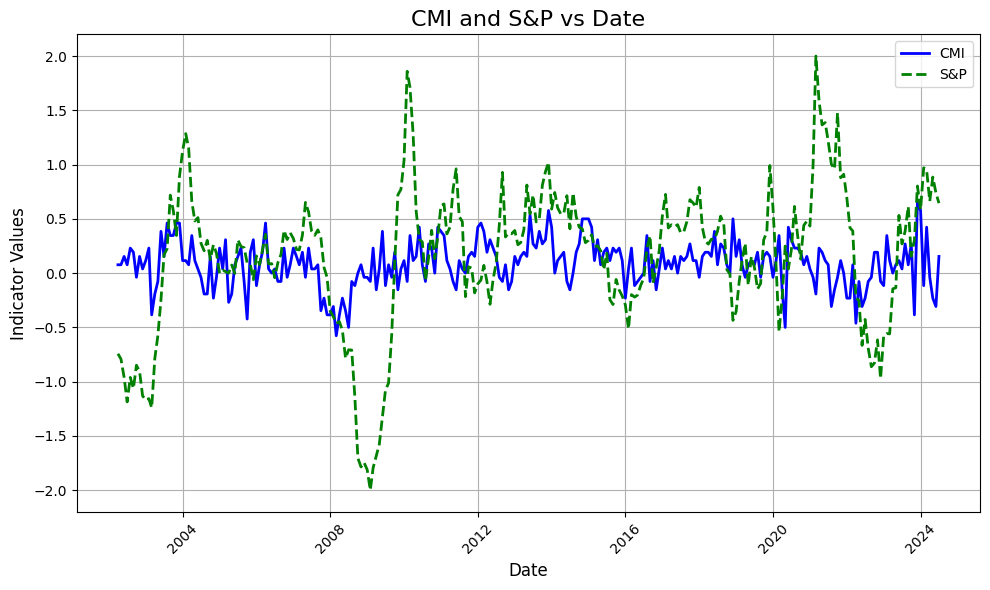

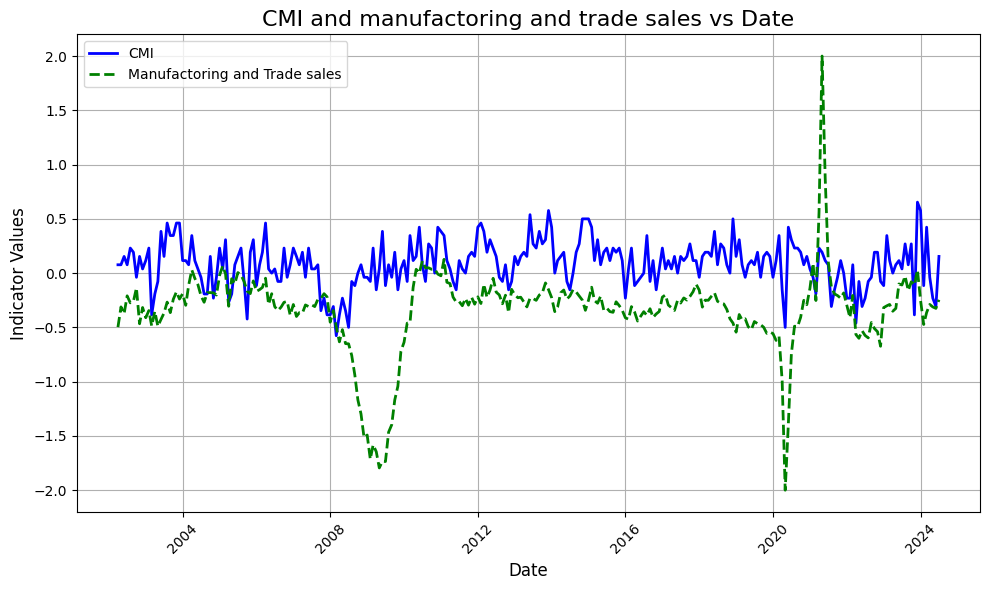

In [64]:
if __name__=="__main__":
    main()

In [65]:
"""
for column in data.columns:
    print(f"Column: {column}")
    print(data[column].value_counts())
    print("\n")
#data_with_CMI
"""

'\nfor column in data.columns:\n    print(f"Column: {column}")\n    print(data[column].value_counts())\n    print("\n")\n#data_with_CMI\n'

In [66]:
# Assuming your dataset is already loaded as 'data'
# Shifting the diffusion data by 6 rows
diffusion_columns = [
    'PMI_CMI', 'Non_Manufacturing_PMI_CMI', 'Jobless_Claims_CMI',
    'Capacity_Utilization_CMI', 'Yield_Curve_CMI', 'Rail_Freight_CMI',
    'Baltic_Dry_CMI', 'CPI_CMI', 'PPI_CMI', 'Import_Price_CMI',
    'Retail_Sales_CMI', 'Real_Bond_Yield_CMI', 'M2_Money_CMI',
    'Credit_Managers_CMI', 'Russell_SP_CMI', 'US_World_CMI',
    'Unit_Labor_Cost_YoY_CMI', 'Oil_Price_CMI', 'New_Home_Sales_CMI',
    'Consumer_Sentiment_CMI', 'Dow_TRAN_UTIL_CMI', 'Breakeven_Inflation_CMI',
    'New_Orders_Inventory_CMI'
]

# Shift the diffusion data by -6 rows (since the dates are descending)
data[diffusion_columns] = data[diffusion_columns].shift(-6)

# Drop rows with NaN values introduced by the shift
data = data.dropna(subset=diffusion_columns)

In [67]:

# Prepare the X (independent variables after the shift) and Y (dependent variable)
X = data[diffusion_columns]  # Independent variables (diffusion data)
Y = data['manufactoring and trade sales']  # Dependent variable (unchanged)

# Initialize the linear regression model
model = LinearRegression()

# Fit the model
model.fit(X, Y)

# Get the regression coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Output the results
print("Intercept:", intercept)
print("Coefficients:", coefficients)

# Optionally, predict future sales based on the model
predicted_sales = model.predict(X)

# Output the predicted sales (optional)
print("Predicted Sales:", predicted_sales)

Intercept: -0.5401846492820606
Coefficients: [-2.28930777e-02  1.74017310e-01  3.60063763e-02  5.00527727e-02
 -3.03398460e-02 -4.14298921e-02 -1.44374014e-02 -3.09328833e-02
 -4.97508600e-02  2.35198488e-02  9.86705616e-04  3.87124036e-02
  4.90152910e-02 -8.80278031e-02 -1.36178197e-02  3.21686548e-02
 -3.31987055e-02 -1.77083695e-02 -4.62397691e-02 -2.76713197e-02
  2.06519639e-02  2.16086771e-02 -8.44362680e-05]
Predicted Sales: [-0.57912774 -0.2788566  -0.31174834 -0.41059855 -0.38804321 -0.13191034
 -0.71833334 -0.43550003 -0.56514235 -0.33648471 -0.24566674 -0.16525753
 -0.32906457 -0.49450822 -0.53422669 -0.24936203 -0.52216507 -0.70478246
 -0.63328493 -0.23138869 -0.3394656  -0.04805498 -0.21504537 -0.38625287
  0.05631195 -0.04001868 -0.13282631  0.09994873 -0.13739757 -0.4454526
 -0.2162741  -0.09950634 -0.2229527  -0.2276496  -0.1343083  -0.16921755
 -0.44310539  0.04325873 -0.22141581 -0.41190048 -0.18507999  0.05679928
 -0.43060601 -0.06135776 -0.17704902 -0.15110888 -0.0

In [68]:

# Prepare the X (independent variables after the shift) and Y (dependent variable)
X = data[diffusion_columns].values  # Independent variables (diffusion data)
Y = data['manufactoring and trade sales'].values  # Dependent variable (unchanged)

# Use Non-Negative Least Squares (NNLS)
coefficients, residuals = nnls(X, Y)

# Output the results
print("Coefficients:", coefficients)

# Optional: Calculate the intercept (mean difference between predicted and actual)
intercept = np.mean(Y - np.dot(X, coefficients))

print("Intercept:", intercept)

# Optionally, predict future sales based on the non-negative model
predicted_sales = np.dot(X, coefficients) + intercept

# Output the predicted sales (optional)
print("Predicted Sales:", predicted_sales)


Coefficients: [0.         0.         0.         0.00928569 0.         0.
 0.         0.         0.         0.         0.02263306 0.06176601
 0.00448539 0.         0.         0.0445898  0.         0.0362219
 0.         0.         0.         0.         0.01438243]
Intercept: -0.32403175818729163
Predicted Sales: [-0.36176739 -0.28629612 -0.32403176 -0.35279662 -0.2952669  -0.5107219
 -0.36133606 -0.30486881 -0.36972374 -0.32234016 -0.22865539 -0.18374937
 -0.27773057 -0.29058385 -0.3257707  -0.34943882 -0.46502992 -0.50839916
 -0.50839916 -0.26792017 -0.3027908  -0.36025366 -0.32990925 -0.44307318
 -0.31383522 -0.53948676 -0.37948374 -0.30946709 -0.35764426 -0.37651208
 -0.47158895 -0.44573514 -0.40139443 -0.42019103 -0.3017084  -0.55778927
 -0.50107265 -0.12490898 -0.19213184 -0.35144534 -0.35666629 -0.26658868
 -0.25642908 -0.38640261 -0.31304795 -0.33568101 -0.35285723 -0.32112071
 -0.29594323 -0.43336992 -0.29576406 -0.26749953 -0.20143037 -0.51896558
 -0.31632562 -0.37726047 -0.1565

In [69]:
# List of diffusion data columns (independent variables)
diffusion_columns = [
    'PMI_CMI', 'Non_Manufacturing_PMI_CMI', 'Jobless_Claims_CMI',
    'Capacity_Utilization_CMI', 'Yield_Curve_CMI', 'Rail_Freight_CMI',
    'Baltic_Dry_CMI', 'CPI_CMI', 'PPI_CMI', 'Import_Price_CMI',
    'Retail_Sales_CMI', 'Real_Bond_Yield_CMI', 'M2_Money_CMI',
    'Credit_Managers_CMI', 'Russell_SP_CMI', 'US_World_CMI',
    'Unit_Labor_Cost_YoY_CMI', 'Oil_Price_CMI', 'New_Home_Sales_CMI',
    'Consumer_Sentiment_CMI', 'Dow_TRAN_UTIL_CMI', 'Breakeven_Inflation_CMI',
    'New_Orders_Inventory_CMI'
]

# Initialize a StandardScaler to perform Z-Score standardization
scaler = StandardScaler()

# Apply the scaler to the diffusion data (independent variables)
data[diffusion_columns] = scaler.fit_transform(data[diffusion_columns])

# Now your diffusion data is normalized and ready for regression

In [70]:
# Initialize a StandardScaler for the dependent variable
scaler_y = StandardScaler()

# Reshape the dependent variable to fit the scaler
data['manufactoring and trade sales'] = scaler_y.fit_transform(data[['manufactoring and trade sales']])


In [71]:
# List of diffusion data columns (independent variables)
diffusion_columns = [
    'PMI_CMI', 'Non_Manufacturing_PMI_CMI', 'Jobless_Claims_CMI',
    'Capacity_Utilization_CMI', 'Yield_Curve_CMI', 'Rail_Freight_CMI',
    'Baltic_Dry_CMI', 'CPI_CMI', 'PPI_CMI', 'Import_Price_CMI',
    'Retail_Sales_CMI', 'Real_Bond_Yield_CMI', 'M2_Money_CMI',
    'Credit_Managers_CMI', 'Russell_SP_CMI', 'US_World_CMI',
    'Unit_Labor_Cost_YoY_CMI', 'Oil_Price_CMI', 'New_Home_Sales_CMI',
    'Consumer_Sentiment_CMI', 'Dow_TRAN_UTIL_CMI', 'Breakeven_Inflation_CMI',
    'New_Orders_Inventory_CMI'
]

# Independent variables (diffusion data after standardization)
X = data[diffusion_columns]

# Dependent variable (manufactoring and trade sales after standardization)
Y = data['manufactoring and trade sales']

# Initialize the linear regression model
model = LinearRegression()

# Fit the model
model.fit(X, Y)

# Get the regression coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Output the results
print("Intercept:", intercept)
print("Coefficients:", coefficients)

# Optionally, predict 'manufactoring and trade sales' based on the model
predicted_sales = model.predict(X)

# Output the predicted sales (optional)
print("Predicted Sales:", predicted_sales)


Intercept: 9.535842590817621e-17
Coefficients: [-6.51040518e-02  4.12546379e-01  9.39869214e-02  1.36855294e-01
 -8.62544287e-02 -1.06923149e-01 -3.98498533e-02 -1.19104482e-01
 -1.84085991e-01  8.62273799e-02  2.64893247e-03  1.38300588e-01
  1.39678345e-01 -2.19534974e-01 -3.64992277e-02  8.69783479e-02
 -7.89488849e-02 -6.28734712e-02 -1.13375942e-01 -6.47556554e-02
  5.32137599e-02  7.73500575e-02 -2.59161183e-04]
Predicted Sales: [-0.61490561  0.16085465  0.07587778 -0.17950495 -0.12123251  0.54049512
 -0.97454781 -0.24383873 -0.57877391  0.01197056  0.24660175  0.45434157
  0.03114073 -0.39628832 -0.49890229  0.23705486 -0.46774069 -0.93953866
 -0.75482247  0.28348955  0.00426933  0.75713817  0.32571306 -0.1166071
  1.02677355  0.7779002   0.53812868  1.13951057  0.52631867 -0.26955154
  0.32253859  0.62421191  0.3052842   0.29314962  0.53429991  0.44411074
 -0.26348744  0.99305011  0.30925482 -0.18286853  0.40312959  1.02803257
 -0.23119489  0.72277     0.42387787  0.49089506  0

In [72]:

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = diffusion_columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Output VIF values
print(vif_data)


                     Variable       VIF
0                     PMI_CMI  1.616975
1   Non_Manufacturing_PMI_CMI  1.519360
2          Jobless_Claims_CMI  1.433480
3    Capacity_Utilization_CMI  1.592848
4             Yield_Curve_CMI  1.464901
5            Rail_Freight_CMI  1.582346
6              Baltic_Dry_CMI  1.176516
7                     CPI_CMI  1.663975
8                     PPI_CMI  2.965797
9            Import_Price_CMI  2.592740
10           Retail_Sales_CMI  1.721266
11        Real_Bond_Yield_CMI  1.221836
12               M2_Money_CMI  1.263429
13        Credit_Managers_CMI  1.384160
14             Russell_SP_CMI  1.254252
15               US_World_CMI  1.188454
16    Unit_Labor_Cost_YoY_CMI  1.116172
17              Oil_Price_CMI  2.004088
18         New_Home_Sales_CMI  1.329118
19     Consumer_Sentiment_CMI  1.196172
20          Dow_TRAN_UTIL_CMI  1.467460
21    Breakeven_Inflation_CMI  1.548694
22   New_Orders_Inventory_CMI  1.119525


In [73]:
# Add a constant (intercept) to the model
X_with_constant = sm.add_constant(X)

# Fit the regression model using OLS (Ordinary Least Squares)
model = sm.OLS(Y, X_with_constant)
results = model.fit()

# Output the summary of the regression model
print(results.summary())


                                  OLS Regression Results                                 
Dep. Variable:     manufactoring and trade sales   R-squared:                       0.366
Model:                                       OLS   Adj. R-squared:                  0.305
Method:                            Least Squares   F-statistic:                     5.986
Date:                           Wed, 09 Apr 2025   Prob (F-statistic):           6.83e-14
Time:                                   19:25:24   Log-Likelihood:                -311.97
No. Observations:                            262   AIC:                             671.9
Df Residuals:                                238   BIC:                             757.6
Df Model:                                     23                                         
Covariance Type:                       nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------

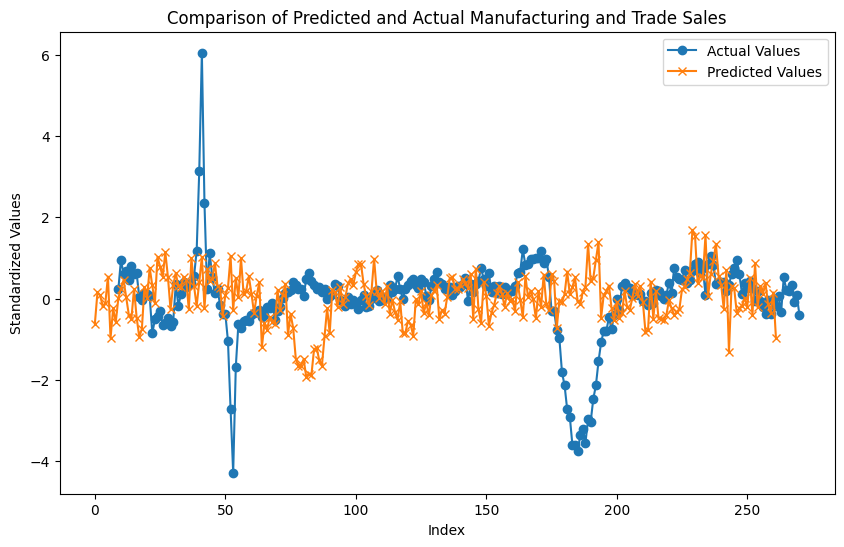

In [74]:
# Make sure the predicted_sales and Y are available
# Y is the actual values of the dependent variable
# predicted_sales is the model's predicted values

# Plot actual and predicted values

plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(Y, label='Actual Values', marker='o')

# Plot predicted values
plt.plot(predicted_sales, label='Predicted Values', marker='x')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Standardized Values')
plt.title('Comparison of Predicted and Actual Manufacturing and Trade Sales')
plt.legend()

# Show the plot
plt.show()


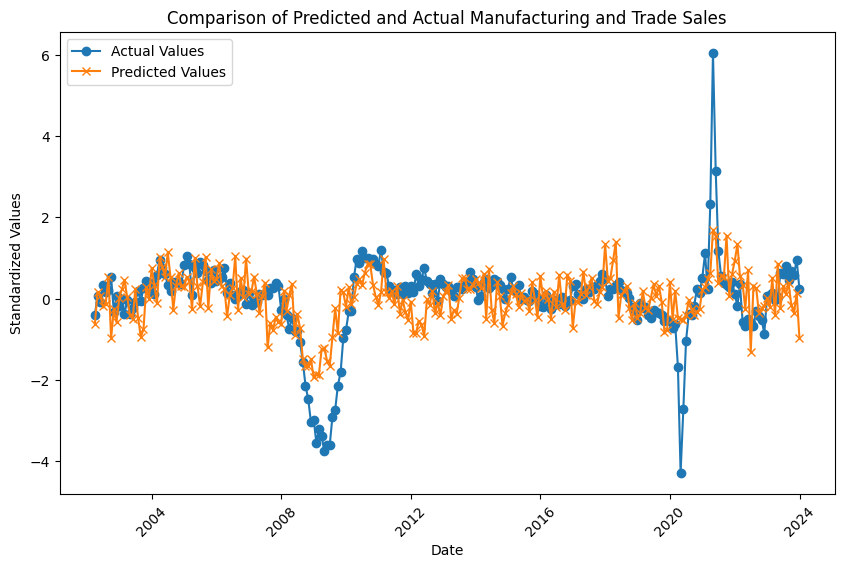

In [75]:
# Assuming 'data' contains the Date column and 'Y' and 'predicted_sales' are already calculated

# Ensure that 'Date' is part of the dataframe
dates = data['Date']

# Create a plot comparing predicted and actual values using the Date column as the x-axis
plt.figure(figsize=(10, 6))

# Plot actual values with Date on x-axis
plt.plot(dates, Y, label='Actual Values', marker='o')

# Plot predicted values with Date on x-axis
plt.plot(dates, predicted_sales, label='Predicted Values', marker='x')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Standardized Values')
plt.title('Comparison of Predicted and Actual Manufacturing and Trade Sales')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

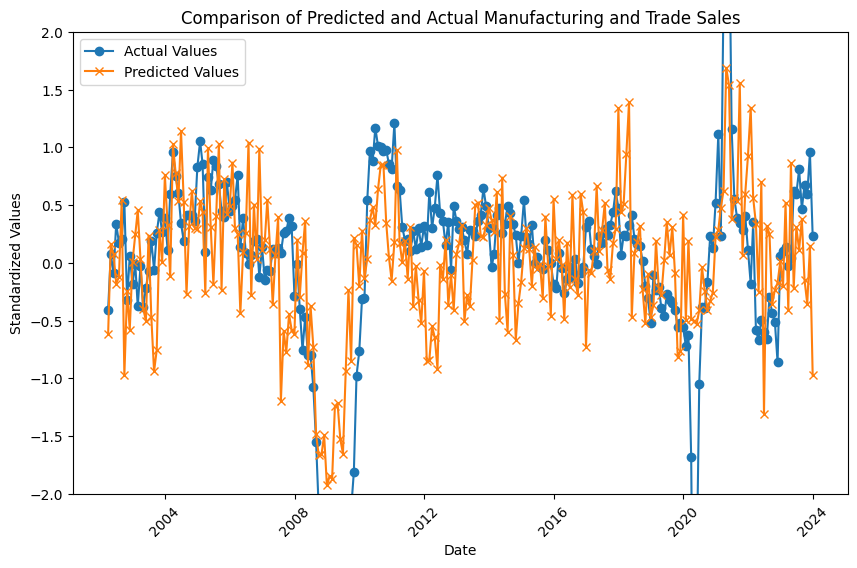

In [76]:
# Ensure that 'Date' is part of the dataframe and 'Y' and 'predicted_sales' are available
dates = data['Date']

# Create a plot comparing predicted and actual values using the Date column as the x-axis
plt.figure(figsize=(10, 6))

# Plot actual values with Date on x-axis
plt.plot(dates, Y, label='Actual Values', marker='o')

# Plot predicted values with Date on x-axis
plt.plot(dates, predicted_sales, label='Predicted Values', marker='x')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Standardized Values')
plt.title('Comparison of Predicted and Actual Manufacturing and Trade Sales')
plt.legend()

# Set y-axis limits to range from -1 to 1
plt.ylim(-2, 2)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


In [77]:
# Calculate the mean and standard deviation of 'manufactoring and trade sales'
mean_sales = np.mean(data['manufactoring and trade sales'])
std_sales = np.std(data['manufactoring and trade sales'])

# Define the thresholds for outliers (mean +/- 2.5 * standard deviation)
upper_threshold = mean_sales + 1.5 * std_sales
lower_threshold = mean_sales - 1.5 * std_sales

# Cap the outliers in the dependent variable
data['manufactoring and trade sales'] = np.where(
    data['manufactoring and trade sales'] > upper_threshold,
    upper_threshold,
    np.where(data['manufactoring and trade sales'] < lower_threshold, lower_threshold, data['manufactoring and trade sales'])
)

# Output the capped 'manufactoring and trade sales' to check results
print(data['manufactoring and trade sales'])

270   -0.404829
269    0.076697
268   -0.086957
267    0.340339
266    0.173407
         ...   
13     0.465779
12     0.674878
11     0.593547
10     0.956649
9      0.233181
Name: manufactoring and trade sales, Length: 262, dtype: float64


In [78]:
# Assuming X (independent variables) and Y (dependent variable 'manufactoring and trade sales') are already prepared

# Prepare X (independent variables - diffusion data)
# Y is the capped 'manufactoring and trade sales' after handling outliers
X = data[diffusion_columns]
Y = data['manufactoring and trade sales']

# Initialize the linear regression model
model = LinearRegression()

# Fit the model
model.fit(X, Y)

# Get the regression coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Output the results
print("Intercept:", intercept)
print("Coefficients:", coefficients)

# Optionally, predict manufacturing and trade sales based on the model
predicted_sales = model.predict(X)

# Output predicted sales
print("Predicted Sales:", predicted_sales)

Intercept: 0.0667385426202319
Coefficients: [ 0.01704335  0.22088256  0.06231108  0.06769995 -0.0387853  -0.06985166
 -0.00751451 -0.07918964 -0.04950534 -0.01974227 -0.01369052  0.09465398
  0.07452919 -0.08040518 -0.06734084  0.03331161 -0.05123004 -0.06373324
 -0.05976606 -0.01713757  0.00738903  0.04199306  0.01413629]
Predicted Sales: [-0.30357759  0.18416829  0.03692718  0.02433308  0.05644552  0.35644751
 -0.53555683 -0.04443425 -0.2225318  -0.05457426  0.09155894  0.3095109
 -0.01477656 -0.25188157 -0.21405229  0.04642547 -0.05933117 -0.42095079
 -0.20424045  0.47677891  0.24016679  0.50650737  0.43166649  0.18602427
  0.85535841  0.58382074  0.4041689   0.70212773  0.30287785 -0.05281726
  0.29833004  0.38558584  0.11837812  0.42103772  0.31029251  0.30976812
  0.01556988  0.64054785  0.32430886  0.13279498  0.24226489  0.81696592
 -0.04603718  0.52113259  0.43793082  0.35292538  0.67886161  0.29740717
  0.2220767  -0.23672567  0.10798945  0.19511514  0.67588856 -0.0908717
  0

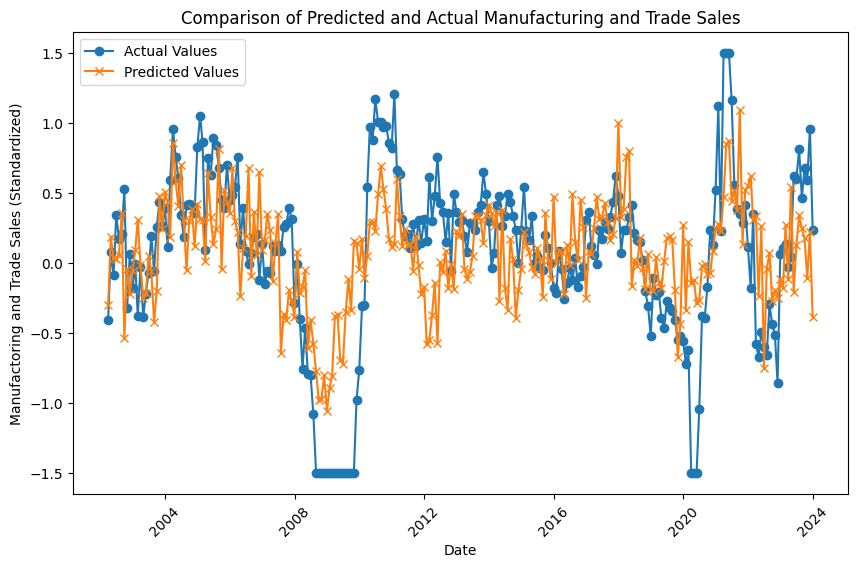

In [79]:
# Ensure 'Date' is part of the dataset and predicted_sales and Y are available
dates = data['Date']

# Create a plot comparing predicted and actual values using Date as the x-axis
plt.figure(figsize=(10, 6))

# Plot actual values with Date on x-axis
plt.plot(dates, Y, label='Actual Values', marker='o')

# Plot predicted values with Date on x-axis
plt.plot(dates, predicted_sales, label='Predicted Values', marker='x')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Manufactoring and Trade Sales (Standardized)')
plt.title('Comparison of Predicted and Actual Manufacturing and Trade Sales')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()